In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.0'

# Training conv3D NN for classify AD, CN and MCI using 3D volume MRI 

In [2]:
import os 
import shutil
import nibabel as nib
import numpy as np
import pandas as pd 

# El path al directorio donde estan las imagenes

dataset_dir = 'C:\ADNI\Imagenes3D'
dataset_labelfile = "C:\ADNI/ADNI1_Complete_1Yr_1.5T.csv"
dataset_labelfile_idfield = 'Image Data ID'
dataset_labelfile_labelfield = 'Group'

#Training parameters

n_dataset_parts = 5 #must be integer
crossval_dataset_frac = 1/n_dataset_parts

FilePathsFromId = {} ## 'ID':path
LabelsFromId = {} ## 'ID':label

IntLabels = {'CN':0, 'AD':1,'MCI':2}

target_shape = (192,192,160)
target_affine = np.array([ [ 4.29048360e-08,  3.24291396e-04, -1.20006235e+00, 9.47253036e+01],
                        [-3.27969076e-04, -1.23945871e+00, -3.13983739e-04, 1.38530121e+02],
                        [-1.25348123e+00,  3.24300145e-04,  4.10763858e-08, 1.08530121e+02],
                        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]
                ])


## Construyendo la red

In [3]:

from keras import layers
from keras import models

model = models.Sequential()

##model.add(layers.Conv3D(32, (3, 3, 3), activation='relu',padding='same',
##                        input_shape=(192, 192, 160,1),data_format='channels_last'))


model.add(layers.AveragePooling3D(pool_size=(2, 2, 2), strides=None, padding='valid',
                         input_shape=(192, 192, 160,1),data_format='channels_last'))
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu',padding='same'))

model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

Veamos como cambian las dimensiones de los mapas de features en cada capa:

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling3d_1 (Average (None, 96, 96, 80, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 96, 96, 80, 32)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 48, 48, 40, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 46, 46, 38, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 23, 23, 19, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 21, 21, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 10, 8, 128)    0         
__________

In [5]:
from keras import optimizers

##sgd = optimizers.SGD(lr=0.01, decay=1e-3, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1.0, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy'])


# Data management functions 

In [5]:
def GenerateDictionariesFromDataset(dataset_dir,dataset_labelfile,dataset_labelfile_idfield,dataset_labelfile_labelfield):
    
    
    CSVDB = GenerateCSVDB(dataset_labelfile,dataset_labelfile_idfield)
    
    FilePaths = GenerateFilePathList(dataset_dir)
        
    return GenerateDictionariesFromFileList(FilePaths,CSVDB,dataset_labelfile_labelfield)
    

def GenerateDictionariesFromFileList(FilePaths,CSVDB,CSVDBField):

    FilePathsFromId = {} ## 'ID':path
    LabelsFromId = {} ## 'ID':label
        
    for filePath in FilePaths:

        Id = IdFromFilePath(filePath) 
        Label = LabelFromId(Id,CSVDB,CSVDBField)
        
        FilePathsFromId[Id] = filePath
        LabelsFromId[Id] = IntLabels[Label]

    return FilePathsFromId,LabelsFromId

def IdFromFilePath(FilePath):
    #expecting filename like id.nii
    Id = FilePath.split('\\')[-1].split('.')[0]
    Id = np.int64(Id)
    return Id

def LabelFromId(Id,CSVDB,CSVDBField):
    return CSVDB.at[Id, CSVDBField]

def GenerateCSVDB(dataset_labelfile,dataset_labelfile_idfield):
    #read CSV file
    CSVDB = pd.read_csv(dataset_labelfile, dtype={dataset_labelfile_idfield:int})
    #Generate index on id field
    CSVDB.set_index(dataset_labelfile_idfield, inplace=True)
    
    return CSVDB

def GenerateFilePathList(dataset_dir):

    FilePaths = []
    for dirname, dirnames, filenames in os.walk(dataset_dir):
        # print path to all subdirectories first.
        for subdirname in dirnames:
            FilePaths.append(os.path.join(dirname, subdirname))

        # print path to all filenames.
        for filename in filenames:
            FilePaths.append(os.path.join(dirname, filename))
            
    return FilePaths

In [6]:
#function to plot loss and accuracy at each epoch end
def PlotAll(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Configure callbacks

In [7]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

def configureCallbacks(nrun):
    patience = 10
    model_filename = 'CN_AD_MCI_Conv3D_CV_GP2_checkpoint_'+str(nrun)+'.h5'
    csv_filename = 'CN_AD_MCI_Conv3D_CV_GP2_Logger_'+str(nrun)+'.CSV'
    # Early stopping for reducing over-fitting risk
    stopper = EarlyStopping(patience=patience,monitor='val_acc')

    # Model checkpoint to save the training results
    checkpointer = ModelCheckpoint(
        filepath=model_filename.format(1),
        verbose=0,
        save_best_only=True,
        save_weights_only=True)

    # CSVLogger to save the training results in a csv file
    csv_logger = CSVLogger(csv_filename.format(1), separator=';')

    callbacks = [checkpointer, csv_logger, stopper]
    
    return callbacks

# Data dictionaries

In [8]:
import random

FilePathsFromId,LabelsFromId = GenerateDictionariesFromDataset(dataset_dir,
                                                               dataset_labelfile,
                                                               dataset_labelfile_idfield,
                                                               dataset_labelfile_labelfield)

#print(FilePathsFromId)
#print(LabelsFromId)

#Ids = list(FilePathsFromId.keys())

#print(Ids)
#print(len(Ids))

c0=0
c1=0
c2=0
Ids0 = []
Ids1 = []
Ids2 = []
indice = 0
for k,v in LabelsFromId.items():
    #print('k:',k,'v:',v)
    if v==0:
        c0 += 1
        Ids0.append(k)  
    if v==1:
        c1 += 1
        Ids1.append(k)  
    if v==2:
        c2 += 1
        Ids2.append(k)  
    
    indice += 1
        
print('CN:',c0,'AD:',c1,'MCI:',c2)
Tot = c0+c1+c2
print('Tot:',Tot)
f0=c0/Tot
f1=c1/Tot
f2=c2/Tot
print('f0:',f0,'f1:',f1,'f2:',f2)

#append ids mantaining proportion
Ids = []
n0 = 0
n1 = 0
n2 = 0
indice = 0

while indice<Tot :
    
    rn = random.random()        # Random float x, 0.0 <= x < 1.0
    
    if rn < f0:
        if n0 < len(Ids0):
            Ids.append(Ids0[n0])      
            n0 += 1
            indice += 1
            
    if rn>=f0 and rn<(f0+f1):
        if n1 < len(Ids1):
            Ids.append(Ids1[n1])      
            n1 += 1
            indice += 1

    if rn>=(f0+f1): 
        if n2 < len(Ids2):
            Ids.append(Ids2[n2])      
            n2 += 1
            indice += 1
    
#print('indice:',indice)
#print(len(Ids)




CN: 703 AD: 476 MCI: 1113
Tot: 2292
f0: 0.3067190226876091 f1: 0.20767888307155322 f2: 0.4856020942408377


# Import trained model

In [9]:
from keras.models import load_model

model = load_model('CN_AD_MCI_Conv3D_CV_GP2_0.h5')

Manual k-Fold Cross Validation
The gold standard for machine learning model evaluation is k-fold cross validation.

It provides a robust estimate of the performance of a model on unseen data. It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset. The process is repeated until all subsets are given an opportunity to be the held out validation set. The performance measure is then averaged across all models that are created
ref:https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

Los criterios para definir la cantidad de epocas por run, el batch_size, la cantidad de steps por epoch tanto para training como para validation fueron tomados de este artículo:
https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

# MAIN

Total images: 2292
training images: 1834
validation images: 458
batch_size: 15
steps_per_epoch: 122
validation_steps: 30
Using  Keras Generator for NIfti images V.12
Using  Keras Generator for NIfti images V.12
**************************************************************
Run 1 / 5
**************************************************************
Epoch 1/50
122/122 [==============================] - 868s 7s/step - loss: 0.3450 - acc: 0.8995 - val_loss: 0.8873 - val_acc: 0.6689
Epoch 2/50
122/122 [==============================] - 814s 7s/step - loss: 0.3259 - acc: 0.9060 - val_loss: 0.9840 - val_acc: 0.6667
Epoch 3/50
122/122 [==============================] - 817s 7s/step - loss: 0.3267 - acc: 0.9011 - val_loss: 0.8626 - val_acc: 0.6800
Epoch 4/50
122/122 [==============================] - 813s 7s/step - loss: 0.3181 - acc: 0.9104 - val_loss: 0.8912 - val_acc: 0.6867
Epoch 5/50
122/122 [==============================] - 817s 7s/step - loss: 0.3075 - acc: 0.9180 - val_loss: 0.8604 - val_

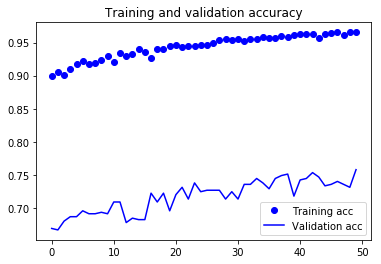

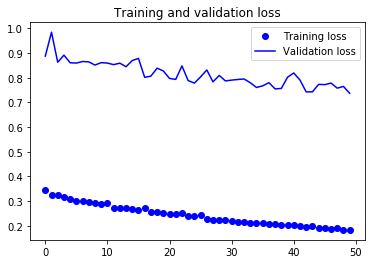

Using  Keras Generator for NIfti images V.12
Using  Keras Generator for NIfti images V.12
**************************************************************
Run 2 / 5
**************************************************************
Epoch 1/50
 69/122 [===============>..............] - ETA: 4:54 - loss: 0.5884 - acc: 0.7874

KeyboardInterrupt: 

In [16]:
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from my_classes import DataGenerator

# Parameters
batch_size = 15
params = {'dim': (192,192,160),
          'batch_size': batch_size,
          'n_classes': 3,
          'n_channels': 1,
          'shuffle': False,
          'target_shape': target_shape,
          'target_affine': target_affine}

partition = {}
labels = {}

nf = len(Ids)
print('Total images:',nf)

nf_part = int( (nf/n_dataset_parts) //1)
print('training images:',nf-nf_part)
print('validation images:',nf_part)

print('batch_size:',batch_size)

epochs_per_run = 50

steps_per_epoch = int(((nf-nf_part)/batch_size)//1)
##steps_per_epoch = 2

print('steps_per_epoch:',steps_per_epoch)

validation_steps = int(((nf_part)/batch_size)//1)
##validation_steps = 10

print('validation_steps:',validation_steps)

cvscores = []

#save in file initial weights 
model.save_weights('CN_AD_MCI_Conv3D_CV_GP2_start_weights.h5')

for nrun in range(n_dataset_parts):
    
    #each run starts with same weigths
    model.load_weights('CN_AD_MCI_Conv3D_CV_GP2_start_weights.h5')
    
    partition['train'] = Ids[0:nrun*nf_part]+Ids[(nrun+1)*nf_part:nf] 
    partition['validation'] = Ids[nrun*nf_part:(nrun+1)*nf_part]
    
    # Generators
    training_generator = DataGenerator(FilePathsFromId, LabelsFromId, partition['train'],  **params)
    validation_generator = DataGenerator(FilePathsFromId, LabelsFromId, partition['validation'],  **params)
    
    print('**************************************************************')
    print('Run',nrun+1,'/',n_dataset_parts)
    print('**************************************************************')
    
    callbacks = configureCallbacks(nrun)
    
    history = model.fit_generator(
        generator=training_generator,
        validation_data=validation_generator,
        use_multiprocessing=False,
        workers=6,
        epochs=epochs_per_run,
        callbacks=callbacks)
    
    model.save('CN_AD_MCI_Conv3D_CV_GP2_'+str(nrun)+'.h5')
    
    # evaluate the model
    
    scores=model.evaluate_generator(validation_generator, steps=validation_steps) # sobre todas las imagenes el set de validacion
    
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    PlotAll(history)
    
print('CV mean:',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

    